In [1]:
from nupack import *
import numpy as np
import matplotlib.pyplot as plt
from Bio.SeqUtils import MeltingTemp as mt
from se_design.sequence_optimization_functions import load_ensemble, get_compseq
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm


In [2]:
def create_tube(seq, temp, my_model, c_seq=None):
    if c_seq is None:
        seqs = [seq, get_compseq(seq)]
    else:
        seqs = [seq, c_seq]
        
    strands = [Strand(seq, name=seq) for seq in seqs]

    c1 = Complex([strands[0]]) 
    c2 = Complex([strands[1]])
    c3 = Complex([strands[0], strands[1]])

    t1 = Tube(strands={strands[0]: 1e-8, strands[1]: 1e-8}, complexes=SetSpec(include=[c1, c2, c3]), name=f'{seq}')

    return t1


def get_unbound_fraction(all_seqs, temp, c_seq=None):
    my_model = Model(material='dna', celsius=temp, sodium=1, magnesium=0)
    
    all_tubes = []
    
    if c_seq is None:
        for seq in all_seqs:
            all_tubes.append(create_tube(seq, temp, my_model))
    else:
        for seq, c_s in zip(all_seqs, c_seq):     
            all_tubes.append(create_tube(seq, temp, my_model, c_seq=c_s))   
    
    tube_results = tube_analysis(tubes=all_tubes, model=my_model)
    
    unbound_fraction = []
    for tube in tube_results.fields[0].values():
        concs = tube.complex_concentrations
        names = [c.name for c in concs]
        bound = 0
        unbound = 0
        for conc, name in zip(concs, names):
            name_split = name.split('+')
            if len(name_split) > 1:
                bound += concs[conc]
            else:
                unbound += concs[conc]
        unbound /= 2
        unbound_fraction.append(unbound / (unbound + bound))
        
    return unbound_fraction


def compute_melting_temp(all_seqs, temp_range=np.linspace(1,100,1), c_seq=None):
    unbound_fractions = {seq: [] for seq in all_seqs}
    
    for temp in temp_range:
        seq_wise_fractions = get_unbound_fraction(all_seqs, temp, c_seq=c_seq)
        for seq, frac in zip(all_seqs, seq_wise_fractions):
            unbound_fractions[seq].append(frac)
            
    melting_temperatures = {}
    for seq, all_fracs in unbound_fractions.items():
        melt = temp_range[np.abs(np.array(all_fracs) - 0.5).argmin()]
        melting_temperatures[seq] = melt
        
    return melting_temperatures, unbound_fractions


def seq_check(seq):
    
    # complocal = get_compseq(seq)
    # if complocal == seq: # don't want homopolymers 
    #     return 0
    
    if 'AAAA' in seq or 'TTTT' in seq or 'GGGG' in seq or 'CCCC' in seq:
        return 0
    elif 'AAAAA' in seq or 'TTTTT' in seq or 'GGGGG' in seq or 'CCCCC' in seq:
        return 0
    elif 'AAAAAA' in seq or 'TTTTTT' in seq or 'GGGGGG' in seq or 'CCCCCC' in seq:
        return 0
    elif 'AAA' in seq or 'TTT' in seq or 'GGG' in seq or 'CCC' in seq:  #newly added 
        return 0
    # elif 'A' == seq[0] or 'T' == seq[0] or 'A' == seq[-1] or 'T' == seq[-1]: #newly added 
    #     return 0
    elif 'A' not in seq or 'T' not in seq or 'G' not in seq or 'C' not in seq:
        return 0 
    # elif seq[0]=='G' or seq[0]=='C' or seq[-1]=='G' or seq[-1]=='G':
    #     return 1
    else:
        return 1 

Text(0, 0.5, 'Unbound Fraction')

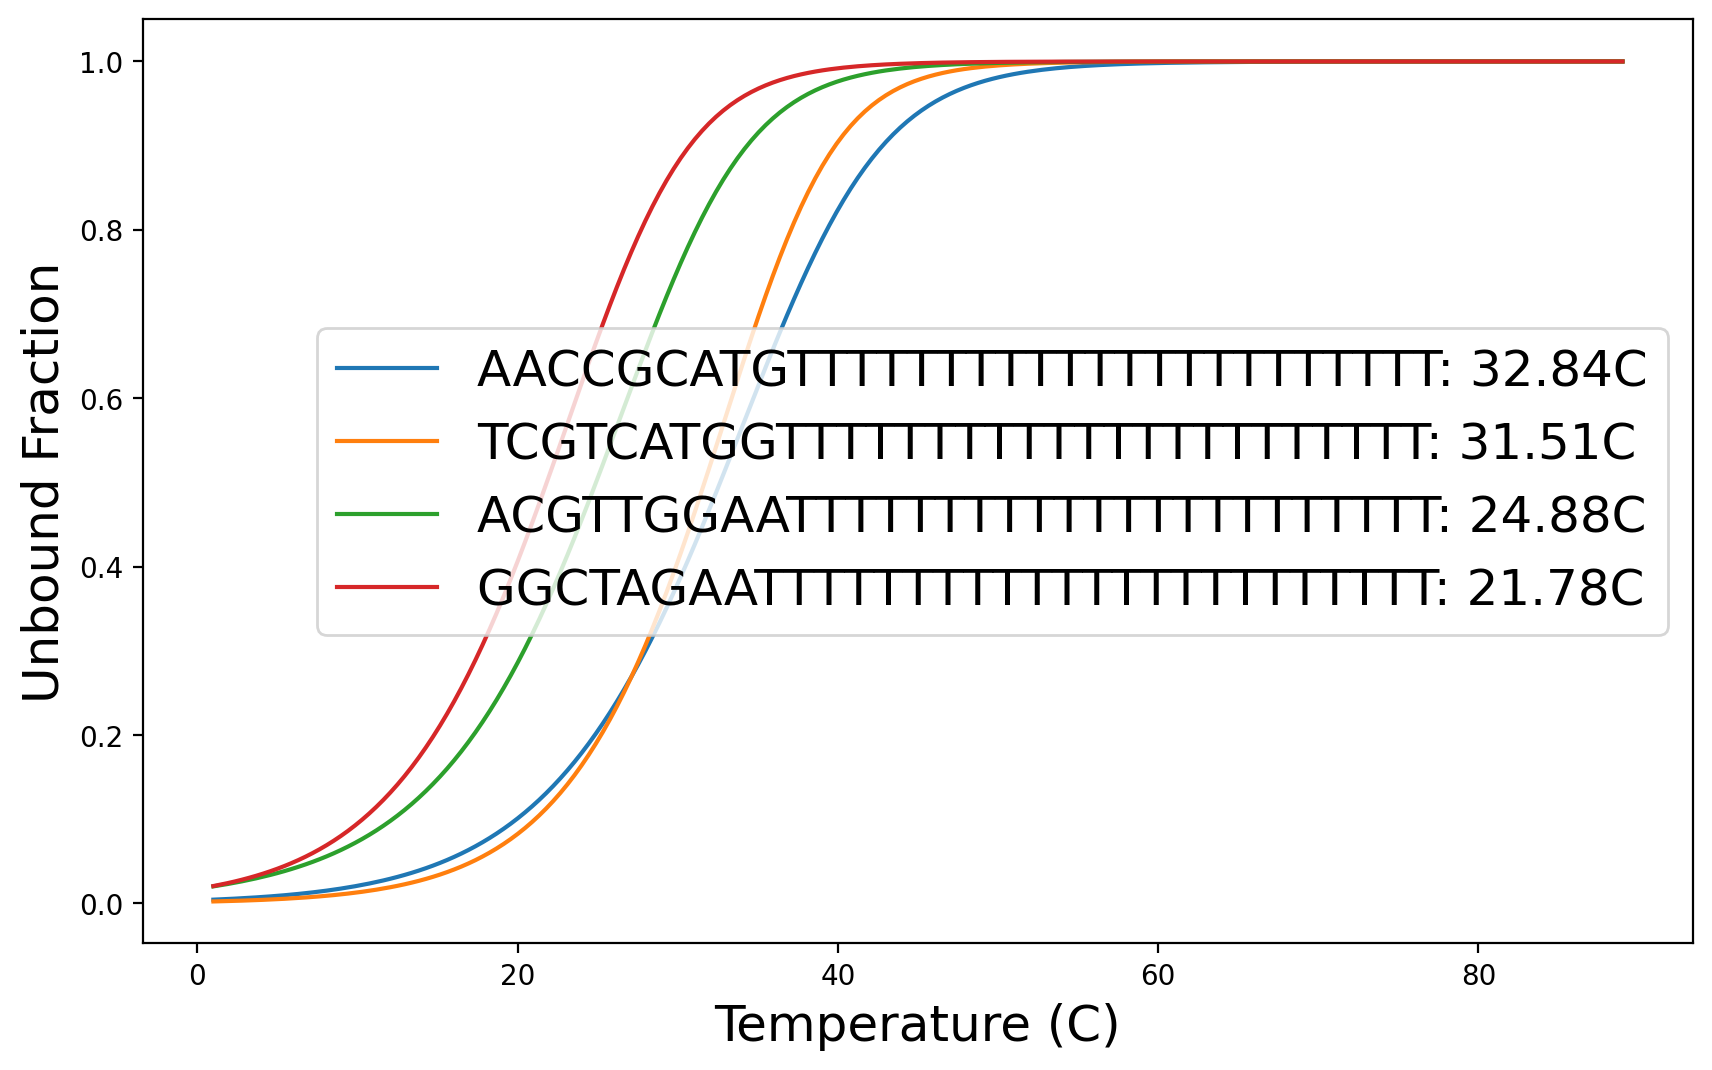

In [7]:
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq

#TTTTTTTTTTTTTTTTTTTTTT
myseqs_0  = [
'AACCGCATGTTTTTTTTTTTTTTTTTTTTTT',
'TCGTCATGGTTTTTTTTTTTTTTTTTTTTTT',
'ACGTTGGAATTTTTTTTTTTTTTTTTTTTTT',
'GGCTAGAATTTTTTTTTTTTTTTTTTTTTTT'
]
my_seqs_1 = [
'CATGCGGTTTTTTTTTTTTTTTTTTTTTTTT',
'CCATGACGATTTTTTTTTTTTTTTTTTTTTT',
'TTCCAACGTTTTTTTTTTTTTTTTTTTTTTT',
'ATTCTAGCCTTTTTTTTTTTTTTTTTTTTTT'
]

temp_range = np.linspace(1,89,200)
melting_temperatures, unbound_fractions = compute_melting_temp(myseqs_0, temp_range=temp_range, c_seq=my_seqs_1)


plt.figure(figsize=(10,6), dpi=200)
for key, unbound_fraction in unbound_fractions.items():
    plt.plot(temp_range, unbound_fraction, label=f'{key}: {melting_temperatures[key]:.2f}C')
plt.legend(fontsize=18)
plt.xlabel('Temperature (C)', fontsize=18)
plt.ylabel('Unbound Fraction', fontsize=18)


# for myseq in myseqs_0:
#     print(myseq)
#     print('%0.2f' % mt.Tm_NN(myseq, dnac1=10, dnac2=10, 
#                              Na=1000, K=0, Tris=0, Mg=0, dNTPs=0, saltcorr=7))
#     print('\n')

In [11]:
print('%0.2f' % mt.Tm_NN('TCGTCATGG', dnac1=10, dnac2=10, 
                             Na=50, K=0, Tris=0, Mg=12.5, dNTPs=0, saltcorr=7))

27.05


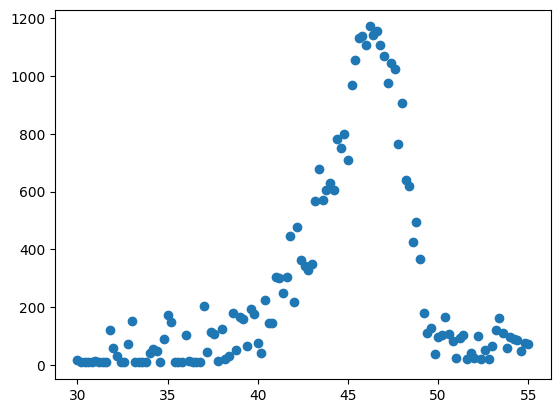

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

# Define the skewed Gaussian function
def skewed_gaussian(x, a, loc, scale, skew):
    return a * skewnorm.pdf(x, skew, loc, scale)

PdI = [55,54.8,54.6,54.4,54.2,54,53.8,53.6,53.4,53.2,53,52.8,52.6,52.4,52.2,52,51.8,51.6,51.4,51.2,51,50.8,50.6,50.4,50.2,50,49.8,49.6,49.4,49.2,49,48.8,48.6,48.4,48.2,48,47.8,47.6,47.4,47.2,47,46.8,46.6,46.4,46.2,46,45.8,45.6,45.4,45.2,45,44.8,44.6,44.4,44.2,44,43.8,43.6,43.4,43.2,43,42.8,42.6,42.4,42.2,42,41.8,41.6,41.4,41.2,41,40.8,40.6,40.4,40.2,40,39.8,39.6,39.4,39.2,39,38.8,38.6,38.4,38.2,38,37.8,37.6,37.4,37.2,37,36.8,36.6,36.4,36.2,36,35.8,35.6,35.4,35.2,35,34.8,34.6,34.4,34.2,34,33.8,33.6,33.4,33.2,33,32.8,32.6,32.4,32.2,32,31.8,31.6,31.4,31.2,31,30.8,30.6,30.4,30.2,30]

Index = [71.57,76.49,49.94,87.81,89.07,98.56,58.18,111.5,163.4,121.4,67.3,20.86,50.36,19.97,99.46,22.88,40.67,20.6,102.2,95.21,24.8,84.81,107.6,166.9,102.7,96.62,39.6,128.5,109.9,179.7,366.5,493.6,426.1,617.6,640.4,905.6,765.1,1025,1046,975.2,1068,1107,1156,1143,1171,1106,1138,1130,1055,969.2,709.3,800,749.1,782.7,606.5,629.6,606.7,571.9,676.4,566.7,349.2,329.6,343.6,361.8,476.9,219.2,445.2,305.8,250.3,300.6,304.9,143.8,143.8,225.5,40.27,75.13,177.2,193.9,64.65,158.8,166.9,53.06,180.9,30.31,19.88,125.1,12.4,106.4,113.5,44.23,205.6,9.505,9.321,10.74,14.8,104.4,10.76,9.764,10.39,148.3,172.5,91.25,9.7,47.67,54.5,42.73,9.52,11.18,8.981,9.813,153.9,73.15,10.39,10.12,30.44,57.44,120.2,9.854,10.25,9.169,13.43,8.938,9.979,8.853,10.16,16.63]

# Initial guess for the parameters
initial_guess = [1, np.mean(PdI), np.std(PdI), 0]

# Fit the data
params, params_covariance = curve_fit(skewed_gaussian, PdI, Index, p0=initial_guess)

# Plot the data and the fit
plt.scatter(PdI, Index, label='Data')
# x = np.linspace(min(PdI), max(PdI), 1000)
# plt.plot(x, skewed_gaussian(x, *params), label='Fitted skewed Gaussian', color='red')
# plt.legend()
# plt.show()